--- 

Reproduce the results from:

Abi Jaber, Illand, and Li (2023). *[The quintic Ornstein-Uhlenbeck volatility model that jointly
calibrates SPX & VIX smiles](https://arxiv.org/pdf/2212.10917)*

---

In [1]:
# TODO:
# - change implementation, simulate normal at each step with antithetic if needed.

# Imports

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import quintic
import quintic_base
from scipy import integrate, interpolate

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
SEED = 1234

/Users/florianbourgey/miniconda3/envs/myenv/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## The quintic Ornstein-Uhlenbeck model

$$
\begin{aligned}
    \frac{dS_t}{S_t} &= \sigma_t \, dW_t^S,  \\
    \\
    \sigma_t &= \sqrt{\xi_0(t)}\frac{p(X_t)}{\sqrt{\mathbb E \left[p(X_t)^2\right]}}, 
    \quad p(x) =\alpha_0 + \alpha_1 x + \alpha_3 x^3 + \alpha_5 x^5,
    \\
    X_t &= \varepsilon^{H-\frac12} \int_0^t e^{-(\frac12-H)\varepsilon^{-1}(t-s)} \, dW_s,
    \quad \varepsilon > 0,
\end{aligned}
$$

where $W$ and $W^S$ are correlated Brownian motions with correlation $\rho$.

## Sanity checks

We check the formula for $\mathbb{E}[p(Z)^2]$ where 
$Z \sim \mathcal{N}\left(\mu, \sigma^2\right)$

In [5]:
a0, a1, a3, a5 = np.abs(np.random.randn(4))
mu = np.random.randn()
sig = np.abs(np.random.randn())
n_quad = 20
estim = quintic.mean_px_squared(
    a0=a0, a1=a1, a3=a3, a5=a5, mu=mu, sig=sig, n_quad=n_quad
)
theoretical = quintic.mean_px_squared(a0=a0, a1=a1, a3=a3, a5=a5, mu=mu, sig=sig)

n_mc = 2 * 10**6
normal = mu + sig * np.random.randn(n_mc)
monte_carlo = np.mean((a0 + a1 * normal + a3 * normal**3 + a5 * normal**5) ** 2)

print(f"Quadrature value: {estim:.5f}")
print(f"MC estimate:      {monte_carlo:.5f}")
print(f"Theoretical value:   {theoretical:.5f}")


def quintic_poly(x):
    return a0 + a1 * x + a3 * x**3 + a5 * x**5


def integrand(x):
    return (quintic_poly(mu + sig * x)) ** 2 * np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


integral = integrate.quad(integrand, -np.inf, np.inf)
print(f"Scipy integral:   {integral[0]:.5f}")

Quadrature value: 194.87184
MC estimate:      195.02114
Theoretical value:   194.87184
Scipy integral:   194.87184


Comparison Shaun's code and our code

In [6]:
T = 1 / 12
n_steps = 200
params = {
    "rho": -0.65,
    "H": -0.1,
    "eps": 1 / 52,
    "a_vec": [0.01, 1, 0.214, 0.227],
}
rho, H, eps, a_vec = (
    params["rho"],
    params["H"],
    params["eps"],
    params["a_vec"],
)
eta_tild = eps ** (H - 0.5)
kappa_tild = (0.5 - H) / eps
a_0, a_1, a_3, a_5 = a_vec
a_k = np.array([a_0, a_1, 0.0, a_3, 0.0, a_5])
n = len(a_k)
tt = np.linspace(0.0, T, n_steps + 1)
std_X_t = np.sqrt(eta_tild**2 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * tt)))
cauchy_product = np.convolve(a_k, a_k)
normal_var = np.sum(
    cauchy_product[np.arange(0, 2 * n, 2)].reshape(-1, 1)
    * std_X_t ** (np.arange(0, 2 * n, 2).reshape(-1, 1))
    * np.array(
        [quintic_base.doublefactorial(z) for z in np.arange(0, 2 * n, 2) - 1]
    ).reshape(-1, 1),
    axis=0,
)

In [8]:
sig = quintic.std_x_ou_quintic(params, t=tt)
normal_var_closed_form = quintic.mean_px_squared(a_0, a_1, a_3, a_5, mu=0, sig=sig)

In [9]:
assert np.allclose(normal_var, normal_var_closed_form)

Compute correlation between

$$
    \delta X_i = \varepsilon^{H-1/2} \int_{t_i}^{t_{i+1}} e^{-(\frac12-H)\varepsilon^{-1}s} \, dW_s
$$

and 

$$
    \delta W_i = \int_{t_i}^{t_{i+1}} dW_s = W_{t_{i+1}} - W_{t_i}
$$

In [10]:
eps = 1e-2
n_steps = 200
T = 1
H = -0.1
t_grid = np.linspace(0, T, n_steps + 1)

In [11]:
# cov dX dW
cov_dX_dW = np.exp(((0.5 - H) / eps) * t_grid[1:]) - np.exp(
    ((0.5 - H) / eps) * t_grid[:-1]
)
cov_dX_dW *= eps ** (0.5 + H) / (0.5 - H)

# var dX
var_dX = (eps ** (2 * H) / (1 - 2 * H)) * (
    np.exp(((1 - 2 * H) / eps) * t_grid[1:]) - np.exp(((1 - 2 * H) / eps) * t_grid[:-1])
)

# var dW
var_dW = t_grid[1:] - t_grid[:-1]


# correlation
rho_dX_dW = cov_dX_dW / np.sqrt(var_dX * var_dW)

rho_dX_dW[:4]

array([0.99627651, 0.99627651, 0.99627651, 0.99627651])

## SPX call/put options by Monte Carlo with antithetic and control variates

Recall $X_t = \varepsilon^{H-\frac12} \int_0^t e^{-(\frac12-H)\varepsilon^{-1}(t-s)} \, dW_s$

Consider $t_k = k \Delta $, $k=0, \ldots, n$, with $\Delta  = T/n$.

Then, we have the recursion

$$
    X_{t_k} 
    = \varepsilon^{H-\frac12} \int_0^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, dW_s
    = e^{-(\frac12-H)\varepsilon^{-1}\Delta} X_{t_{k-1}} + \delta X_k,
$$

where

$$
\delta X_k = \varepsilon^{H-\frac12} \int_{t_{k-1}}^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, dW_s
\sim \mathcal N \left(0, \mathbb{E}[\delta X_k^2]\right).
$$

and 

$$
\mathbb{E}[\delta X_k^2] = \frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}\Delta}\right).
$$

We need to compute the covariance between $\delta X_k$ 
and $\delta W_k^S = \int_{t_{k-1}}^{t_k} dW_s^S = W_{t_k}^S - W_{t_{k-1}}^S \sim \mathcal N \left(0, \Delta\right)$.


It is given by

$$
\mathbb{E}[\delta X_k \, \delta W_k^S]
= \rho \varepsilon^{H-\frac12} \int_{t_{k-1}}^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, ds
= \rho \frac{\varepsilon^{H+\frac12}}{\frac12-H}\left(1 - e^{-(\frac12-H)\varepsilon^{-1}\Delta}\right).
$$

---

VIX simulation

By definition, 

$$
\mathrm{VIX}_T^2
= \frac{1}{\Delta} \int_T^{T+\Delta} \xi_T(u) \, du
$$

where $\xi_T(u) = \mathbb{E}[\sigma_u^2 | \mathcal{F}_T]$.

Observe that

$$
    X_u = X_T e^{-(\frac12-H)\varepsilon^{-1}(u-T)} + \varepsilon^{H-\frac12} \int_T^u e^{-(\frac12-H)\varepsilon^{-1}(u-s)} \, dW_s.
$$

Hence, conditionnally on $\mathcal{F}_T$, $X_u$ is Gaussian with mean 
$$
\mathbb{E}[X_u | \mathcal{F}_T] = X_T e^{-(\frac12-H)\varepsilon^{-1}(u-T)}
$$
and variance
$$
\mathrm{Var}[X_u | \mathcal{F}_T]
= \frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}(u-T)}\right).   
$$

Recall that $X_T$ is a centered normal random variable with variance
$$
\mathrm{Var}[X_T] = \frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}T}\right).
$$

Denote $h(\mu,\sigma) = E[p(Z)^2]$ where $Z \sim N(\mu,\sigma^2)$

Then, we have

$$
    \xi_T(u) = \xi_0(u) f^u(T,X_T)
$$

where $f^u(T,x)$ is a deterministic function given by

$$
    f^u(T,x)
    = \frac{h\left(x e^{-(\frac12-H)\varepsilon^{-1}(u-T)}, \sqrt{\frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}(u-T)}\right)}\right)}{h\left(0, \sqrt{\frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}u}\right)}\right)}.  
$$

In [4]:
np.random.seed(SEED)
n_steps = 600
n_mc = 5 * 10**4
S0 = 1.0
T = 1 / 12
ks = np.linspace(-0.2, 0.03, 50)  # log-moneyness
Ks = np.exp(ks) * S0  # strikes

In [5]:
params = {
    "rho": -0.65,
    "H": -0.1,
    "eps": 1 / 52,
    "a_vec": [0.01, 1, 0.214, 0.227],
}

In [6]:
w1 = quintic_base.gen_bm_path(n_steps, n_mc)
w1 = np.insert(w1, 0, 0, axis=0)  # W_0 = 0
T_array_nodes = np.array([0, 0.03, 1 / 12, 2 / 12, 3 / 12, 6 / 12, 12 / 12, 24 / 12])
fv_nodes = np.ones_like(T_array_nodes) * 0.02  # fix fwd variance at 0.02

In [ ]:
p_mc_cv1, std_mc_cv1, imp_mc, imp_mc_upper, imp_mc_lower = (
    quintic_base.mc_polynomial_fwd_var(
        T=T,
        S0=S0,
        strike_array=Ks,
        n_steps=n_steps,
        fv_nodes=fv_nodes,
        T_array_nodes=T_array_nodes,
        w1=w1,
        rho=params["rho"],
        H=params["H"],
        eps=params["eps"],
        a_k_part=params["a_vec"],
        N_sims=n_mc,
    )
)

In [20]:
# p_mc, std_mc, imp_mc, imp_mc_upper, imp_mc_lower = quintic.mc_polynomial_fwd_var(
#     params=params,
#     T=T,
#     S0=S0,
#     Ks=Ks,
#     n_steps=n_steps,
#     n_mc=n_mc,
#     fv_nodes=fv_nodes,
#     T_array_nodes=T_array_nodes,
#     w1=w1,
# )

In [21]:
impvols = quintic.simulate_quintic_ou(
    params=params,
    xi0=lambda t: 0.02 * np.ones_like(t),
    T=T,
    k=ks,
    n_steps=n_steps,
    n_mc=n_mc,
    seed=SEED,
    antithetic=True,
)

In [16]:
# S_T = quintic.simulate_quintic_ou(
#     params=params,
#     xi0=lambda t: 0.02 * np.ones_like(t),
#     T=T,
#     k=ks,
#     n_steps=n_steps,
#     n_mc=n_mc,
#     seed=SEED,
#     antithetic=False,
#     return_paths=True,
# )

In [17]:
# from black import black_impvol

# iv_direct = np.zeros_like(Ks)
# for i, K in enumerate(Ks):
#     if K < 1.0:
#         price = np.mean(np.maximum(K - S_T, 0))
#         iv_direct[i] = black_impvol(F=S0, K=K, T=T, value=price, opttype=-1)
#     else:
#         price = np.mean(np.maximum(S_T - K, 0))
#         iv_direct[i] = black_impvol(F=S0, K=K, T=T, value=price, opttype=1)

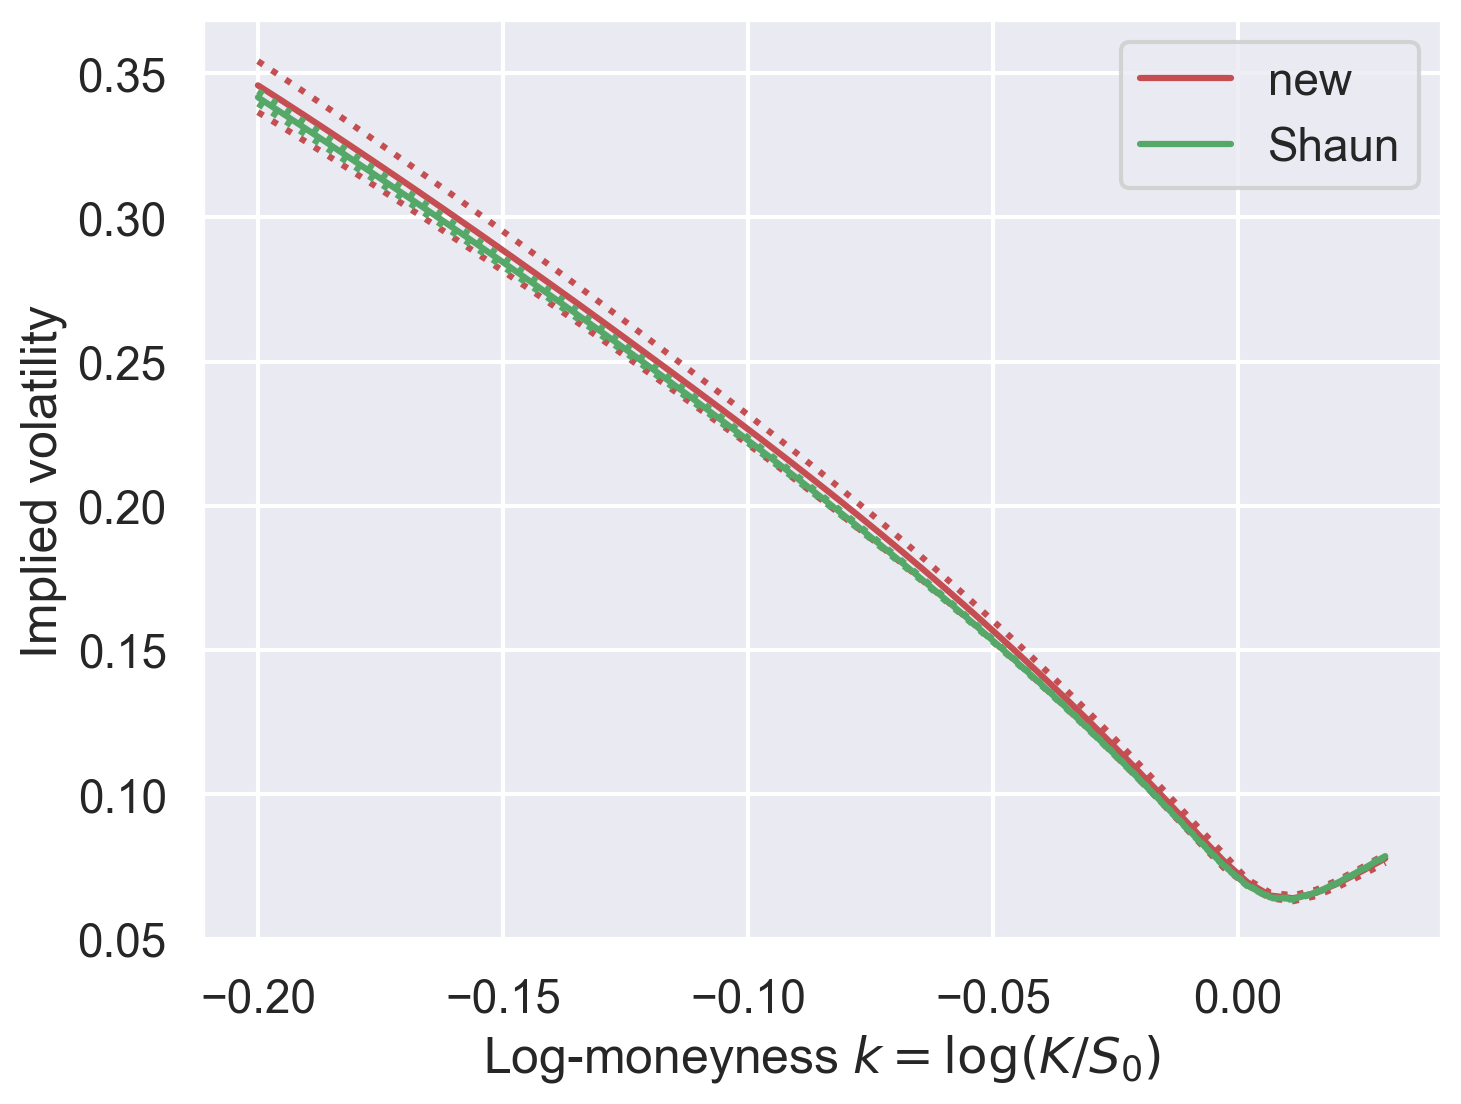

In [22]:
fig, ax = plt.subplots()
ax.plot(ks, impvols["otm_impvol"], "r-", label="new")
ax.plot(ks, impvols["otm_impvol_high"], ":r")
ax.plot(ks, impvols["otm_impvol_low"], ":r")
ax.plot(ks, imp_mc, "g-", label="Shaun")
ax.plot(ks, imp_mc_upper, ":g")
ax.plot(ks, imp_mc_lower, ":g")
ax.set_xlabel(r"Log-moneyness $k = \log(K/S_0)$")
ax.set_ylabel("Implied volatility")
ax.legend()
plt.show()

## VIX call/put options by Gaussian quadrature

In [11]:
# gaussian quadrature
deg_vix = 800
x_org_vix, w_org_vix = np.polynomial.legendre.leggauss(deg_vix)
lb_vix = -8
ub_vix = 8

In [12]:
lm_vix = np.linspace(-0.1, 1, 50)
vix_strike_perc = np.exp(lm_vix)

In [13]:
vix_fut, vix_call, vix_iv = quintic_base.vix_all_integration_poly_fast_revert_model(
    params["H"],
    params["eps"],
    T,
    params["a_vec"],
    x_org_vix,
    w_org_vix,
    vix_strike_perc,
    fv_nodes,
    T_array_nodes,
)

In [19]:
# new code
xi0 = lambda t: 0.02 * np.ones_like(t)
n_quad = 80
ks = np.linspace(-0.1, 1, 50)
F = quintic.fut_vix(params, xi0=xi0, T=T, n_quad=n_quad)
Ks = F * np.exp(ks)

impvol_vix_new = quintic.impvol_vix(params=params, xi0=xi0, K=Ks, T=T, n_quad=n_quad)

[0.00498916 0.00661559 0.00838817 0.01030891 0.01235879 0.01291296
 0.01218379 0.01150975 0.01088407 0.01029328 0.00972866 0.0092194
 0.00872922 0.00826711 0.00783951 0.00742505 0.00704678 0.00668011
 0.00633653 0.00601733 0.00569245 0.00541991 0.00514119 0.00486928
 0.00463691 0.00439926 0.00415723 0.00396494 0.00376829 0.00356717
 0.00337726 0.00322073 0.00306064 0.00289692 0.00272948 0.00260401
 0.00248033 0.00235385 0.0022245  0.00209221 0.00198583 0.00189515
 0.00180241 0.00170756 0.00161056 0.00151136 0.00141155 0.00135096
 0.00128899 0.00122561]


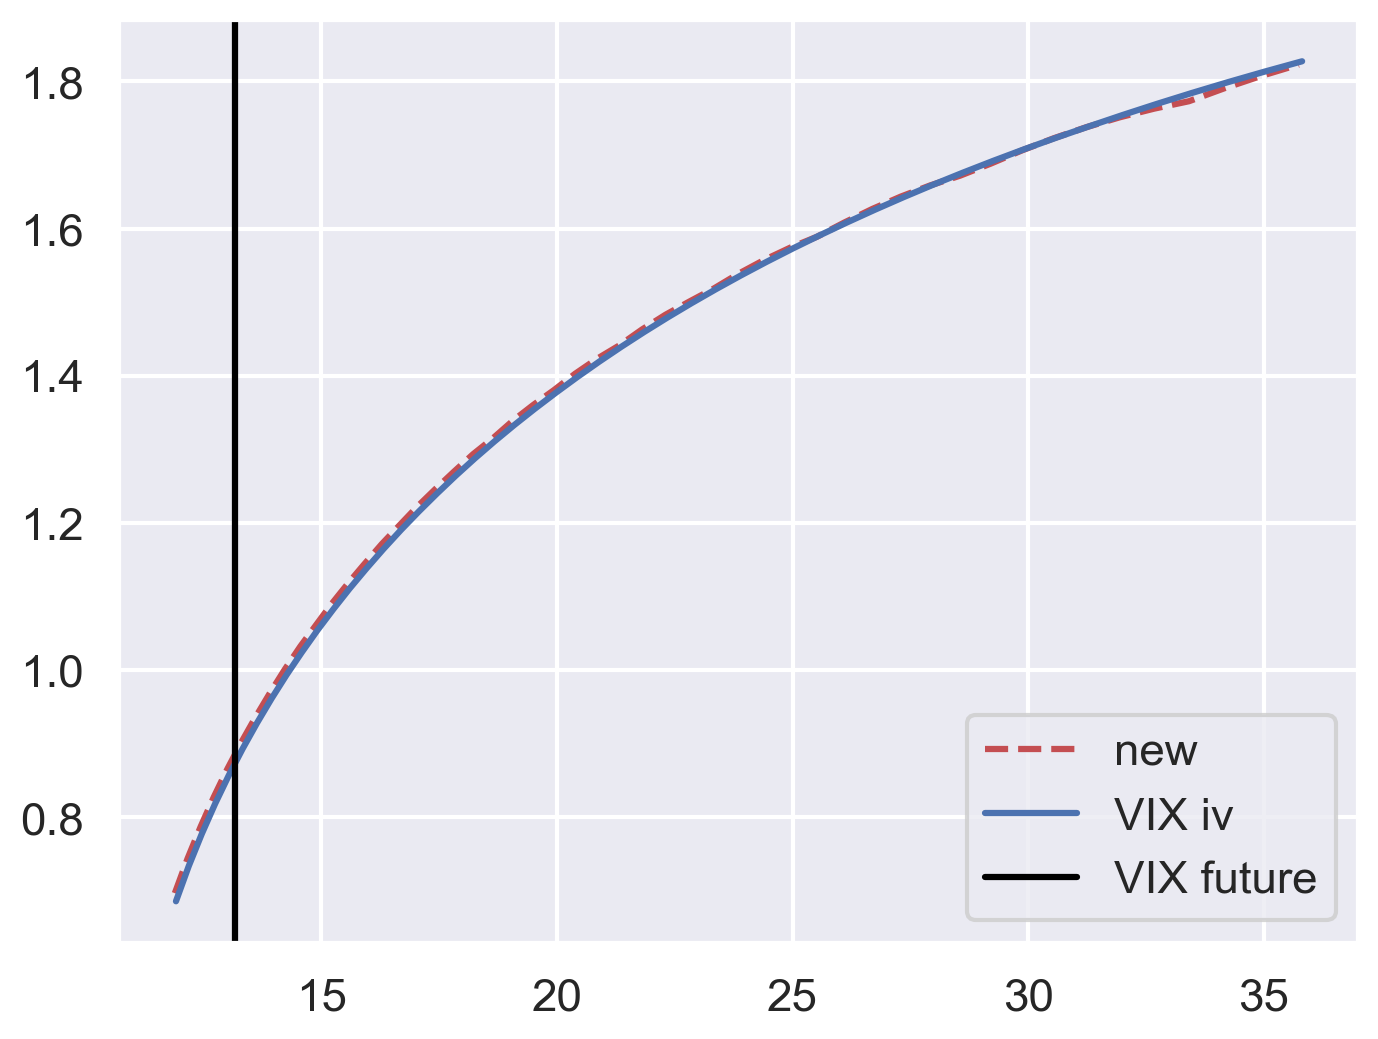

In [20]:
fig, ax = plt.subplots()
ax.plot(100 * Ks, impvol_vix_new, "r--", label="new")
ax.plot(vix_strike_perc * vix_fut, vix_iv, label="VIX iv")
ax.axvline(x=vix_fut, color="black", label="VIX future")
ax.legend()
plt.show()

In [45]:
quintic.fut_vix(params, xi0=lambda t: 0.02 * np.ones_like(t), T=T, n_quad=80)

np.float64(0.13153331167652516)

In [46]:
vix_fut

np.float64(13.173288520184204)

array([0.70726961, 0.75868636, 0.79839021, 0.8287546 , 0.85110158,
       0.89301497, 0.93939513, 0.980241  , 1.01609737, 1.04732484,
       1.0741505 , 1.09669477, 1.11498922, 1.12898022, 1.15764946,
       1.19305938, 1.22602671, 1.25659496, 1.28477961, 1.31057233,
       1.33394033, 1.35482341, 1.37313277, 1.38874799, 1.40150636,
       1.41119748, 1.42242461, 1.4512524 , 1.47878677, 1.50500447,
       1.5298751 , 1.55335814, 1.5754047 , 1.5959546 , 1.61493272,
       1.63225144, 1.64780289, 1.66145712, 1.67305499, 1.68240041,
       1.68924958, 1.69329435, 1.70233399, 1.72568709, 1.74822599,
       1.7699191 , 1.79072946, 1.81061417, 1.82952374, 1.84740156])

In [37]:
vix_strike_perc * vix_fut

array([11.91968437, 12.19029523, 12.46704972, 12.75008733, 13.0395507 ,
       13.33558572, 13.63834158, 13.94797086, 14.26462961, 14.58847741,
       14.91967749, 15.25839675, 15.6048059 , 15.95907953, 16.32139619,
       16.69193847, 17.07089311, 17.45845111, 17.85480777, 18.26016287,
       18.67472068, 19.09869014, 19.53228492, 19.97572353, 20.42922947,
       20.89303129, 21.36736273, 21.85246285, 22.34857612, 22.85595259,
       23.37484795, 23.90552371, 24.44824733, 25.00329232, 25.57093842,
       26.1514717 , 26.74518475, 27.35237678, 27.97335379, 28.60842877,
       29.25792175, 29.92216008, 30.60147851, 31.29621942, 32.00673292,
       32.73337711, 33.47651819, 34.2365307 , 35.01379767, 35.80871081])